# NTechLab Male of Female Classificator



Загрузим данные с google drive. Этот код можно закомментировать, если ноутбук выполняется локально

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!tar -xf drive/My\ Drive/Colab\ Notebooks/internship_data.tar.gz


Mounted at /content/drive


Импортируем библиотеки

In [ ]:
import json
import numpy as np
import os
import csv
import urllib
import re
import time
from PIL import Image
# from skimage import io, transform

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import models, transforms
from torch.utils.data import Dataset, SubsetRandomSampler
# from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
train_folder = 'internship_data'
print('Number of files in the male folder', len(os.listdir(os.path.join(train_folder, 'male'))))
print('Number of files in the female folder', len(os.listdir(os.path.join(train_folder,'female'))))

Number of files in the male folder 50002
Number of files in the female folder 50002


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

создадим датасет

In [ ]:
class MaleFemaleDataset(Dataset):
    def __init__(self, path, transform=None):
        folder_male = os.path.join(path, "male")
        folder_female = os.path.join(path, "female")
        self.folders = [folder_male, folder_female]
        male_len = len([f for f in os.listdir(folder_male) if f.endswith(".jpg")])
        female_len = len([f for f in os.listdir(folder_female) if f.endswith(".jpg")])

        self.length = male_len + female_len
        self.transform = transform
        img_dict = []
        for i, folder in enumerate(self.folders):
            for imgname in os.listdir(folder):
                if imgname.endswith('jpg'):
                  img_dict.append({'name': imgname,
                                    'y': i
                                  })

        self.img_dict = img_dict
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):        
        if torch.is_tensor(index):
            index = index.tolist()
        image = self.img_dict[index]
        y = image['y']
        img = Image.open(os.path.join(self.folders[y],image['name']))
        if self.transform:
            img = self.transform(img)

        return img, y, int(index)



Визуализируем несколько примеров из нашей выборки

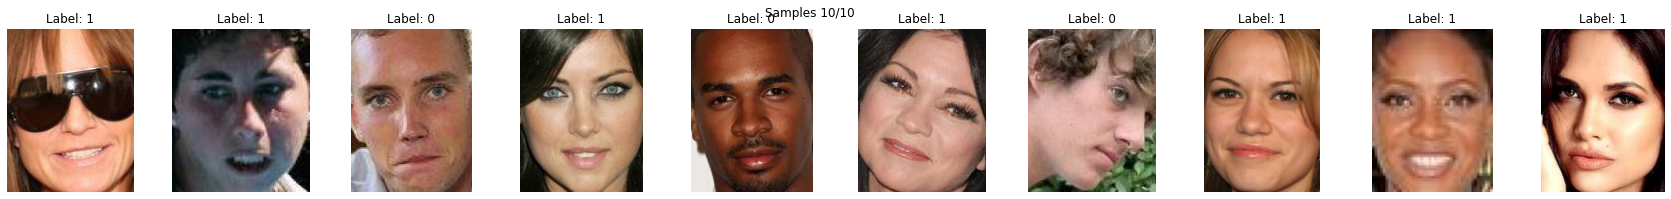

In [ ]:
def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = MaleFemaleDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 10, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

# Функции для тренировки

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs, save=None, save_name='model'):    
  
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    

            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            if scheduler:
              scheduler.step()
  
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        


        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        if save and not epoch % save:
          tm = int(time.time())
          acc = int(val_accuracy*10000)
          path = f"drive/My Drive/Colab Notebooks/models/{save_name}.{epoch}.{acc}.{tm}.torch"
          print(f"save model to {path}")
          torch.save(model.state_dict(), path)
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0

    for i_step, (x, y,_) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)    
            
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]
    return float(correct_samples)/ total_samples

# Создадим датасет


In [ ]:
img_transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
train_dataset = MaleFemaleDataset(train_folder, 
                       transform=img_transform
                      )
loss = nn.CrossEntropyLoss()
batch_size = 32


Напишем метод для создания модели. Параметр requires_grad задает, будут ли внутренние слои сети обучаемыми

In [ ]:
def get_model(requires_grad=False):
    model = models.resnet18(pretrained=True)

    if not requires_grad:
      for param in model.parameters():
          param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)

    return model



# Подбор гиперпараметров

Попробуем оценить на части выборки, какие параметры нам нужны для успешной тренировки. 
Для этого возьмем от датасета 2000 картинок для обучения и 500 для валидации

In [ ]:

data_size = len(train_dataset)
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

train_indices = indices[:2000]
val_indices = indices[2000:2500]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)


Начнем с варианта, когда обучается только последний слой. Попробуем подобрать lr 



Average loss: 0.746470, Train accuracy: 0.502000, Val accuracy: 0.520000
Average loss: 0.704856, Train accuracy: 0.553500, Val accuracy: 0.548000
Average loss: 0.654106, Train accuracy: 0.618000, Val accuracy: 0.630000
Average loss: 0.678438, Train accuracy: 0.599500, Val accuracy: 0.658000
Average loss: 0.566337, Train accuracy: 0.709000, Val accuracy: 0.776000
Average loss: 1.338760, Train accuracy: 0.698500, Val accuracy: 0.866000
Average loss: 6.158621, Train accuracy: 0.675500, Val accuracy: 0.584000
Average loss: 34.338268, Train accuracy: 0.674500, Val accuracy: 0.864000


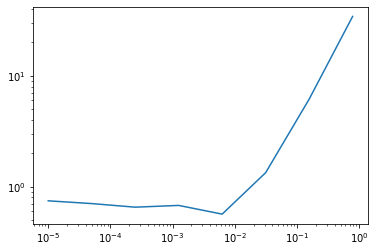

In [ ]:

start_lr = 1e-5
end_lr = 1.0

cur_lr = start_lr
lr_multiplier = 10
losses = []
lrs = []
while cur_lr <= end_lr:
    model = get_model()
    optimizer = optim.SGD( model.fc.parameters(), lr=cur_lr)
    loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, None, 1)

    # loss = train_model(batch=i)
    losses.append(loss_history[0])
    lrs.append(cur_lr)
    cur_lr = cur_lr*lr_multiplier # increase LR

plt.xscale('log')
plt.yscale('log')

plt.plot(lrs,losses)

А теперь попробуем обучить все слои

Average loss: 0.703297, Train accuracy: 0.572000, Val accuracy: 0.552000
Average loss: 0.722450, Train accuracy: 0.544000, Val accuracy: 0.574000
Average loss: 0.632881, Train accuracy: 0.665000, Val accuracy: 0.730000
Average loss: 0.563029, Train accuracy: 0.714500, Val accuracy: 0.692000
Average loss: 4.121376, Train accuracy: 0.668000, Val accuracy: 0.522000
Average loss: 43.582600, Train accuracy: 0.672000, Val accuracy: 0.490000


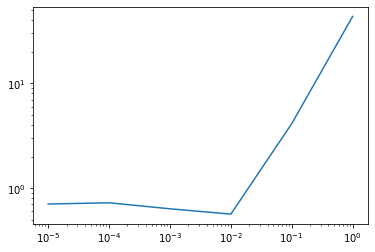

In [ ]:

start_lr = 1e-5
end_lr = 1.0

cur_lr = start_lr
lr_multiplier = 10
losses = []
lrs = []
while cur_lr <= end_lr:
    model = get_model(requires_grad=True)
    optimizer = optim.SGD( model.fc.parameters(), lr=cur_lr)
    loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, None, 1)

    # loss = train_model(batch=i)
    losses.append(loss_history[0])
    lrs.append(cur_lr)
    cur_lr = cur_lr*lr_multiplier # increase LR

plt.xscale('log')
plt.yscale('log')

plt.plot(lrs,losses)

Loss немного меньше. Значит выгоднее обучать всю сеть целиком. 
Попробуем подобрать lr для внутренних слоев. Для последнего полносвязного слоя зафиксируем lr=0.01


Average loss: 0.555967, Train accuracy: 0.723500, Val accuracy: 0.784000
Average loss: 0.594470, Train accuracy: 0.702000, Val accuracy: 0.778000
Average loss: 0.534714, Train accuracy: 0.730500, Val accuracy: 0.866000
Average loss: 0.554514, Train accuracy: 0.718500, Val accuracy: 0.806000
Average loss: 0.520108, Train accuracy: 0.732500, Val accuracy: 0.868000
Average loss: 0.570309, Train accuracy: 0.703000, Val accuracy: 0.824000
Average loss: 0.527775, Train accuracy: 0.736000, Val accuracy: 0.806000
Average loss: 0.533604, Train accuracy: 0.752000, Val accuracy: 0.856000


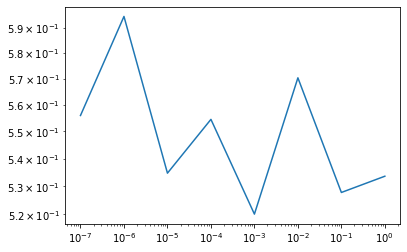

In [ ]:
start_lr = 1e-7
end_lr = 1.0

cur_lr = start_lr
lr_multiplier = 10
losses = []
lrs = []
while cur_lr <= end_lr:
    model = get_model(requires_grad=True)
    parameters = model.fc.parameters()   

    params = model.state_dict()
    params.pop('fc.bias')
    params.pop('fc.weight')

    optimizer = optim.SGD( [
        {'params': params.values(), },
        {'params': model.fc.parameters(), 'lr': 1e-2}],
        lr=cur_lr)

    loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, None, 1)

    losses.append(loss_history[0])
    lrs.append(cur_lr)
    cur_lr = cur_lr*lr_multiplier 

plt.xscale('log')
plt.yscale('log')

plt.plot(lrs,losses)




Добавим momentum

momentum: 0
Average loss: 0.549974, Train accuracy: 0.721500, Val accuracy: 0.596000
Average loss: 0.419493, Train accuracy: 0.816000, Val accuracy: 0.858000
Average loss: 0.328152, Train accuracy: 0.868000, Val accuracy: 0.848000
momentum: 0.85
Average loss: 0.578406, Train accuracy: 0.713500, Val accuracy: 0.738000
Average loss: 0.400266, Train accuracy: 0.826500, Val accuracy: 0.778000
Average loss: 0.349367, Train accuracy: 0.848000, Val accuracy: 0.890000
momentum: 0.9
Average loss: 0.563243, Train accuracy: 0.701000, Val accuracy: 0.738000
Average loss: 0.360409, Train accuracy: 0.844500, Val accuracy: 0.830000
Average loss: 0.327964, Train accuracy: 0.871500, Val accuracy: 0.734000
momentum: 0.95
Average loss: 0.546030, Train accuracy: 0.730000, Val accuracy: 0.856000
Average loss: 0.383470, Train accuracy: 0.838000, Val accuracy: 0.830000
Average loss: 0.339409, Train accuracy: 0.857000, Val accuracy: 0.896000
momentum: 0.96
Average loss: 0.516876, Train accuracy: 0.753500, Val

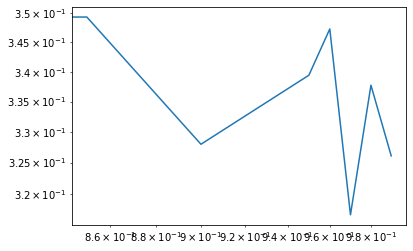

In [ ]:
start_lr = 1e-7
end_lr = 1.0

cur_lr = start_lr
lr_multiplier = 10
losses = []
momentums = []
for momentum in [0, 0.85,0.9,0.95,0.96,0.97,0.98,0.99]:
    print(f"momentum: {momentum}")
    model = get_model(requires_grad=True)
    parameters = model.fc.parameters()   

    params = model.state_dict()
    params.pop('fc.bias')
    params.pop('fc.weight')

    optimizer = optim.SGD( [
        {'params': params.values(), },
        {'params': model.fc.parameters(), 'lr': 1e-2}],
        lr=1e-3)

    
    loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, None, 3)

    losses.append(loss_history[-1])
    momentums.append(momentum)

plt.xscale('log')
plt.yscale('log')

plt.plot(momentums,losses)




Лучший momentum = 0.98

попробуем другие методы оптимизации

Average loss: 0.760400, Train accuracy: 0.482000, Val accuracy: 0.490000
Average loss: 0.755524, Train accuracy: 0.468000, Val accuracy: 0.480000
Average loss: 0.770020, Train accuracy: 0.458000, Val accuracy: 0.444000
Average loss: 0.725061, Train accuracy: 0.520500, Val accuracy: 0.624000
Average loss: 0.483594, Train accuracy: 0.793000, Val accuracy: 0.878000
Average loss: 0.591218, Train accuracy: 0.748500, Val accuracy: 0.896000
Average loss: 2.842843, Train accuracy: 0.787500, Val accuracy: 0.834000
Average loss: 29.996330, Train accuracy: 0.762500, Val accuracy: 0.878000


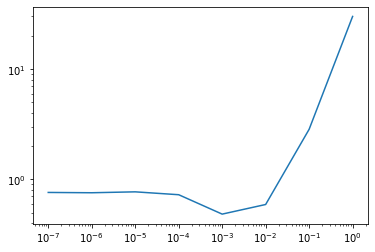

In [ ]:
start_lr = 1e-7
end_lr = 1.0

cur_lr = start_lr
lr_multiplier = 10
losses = []
lrs = []
while cur_lr <= end_lr:
    model = get_model(requires_grad=False)
    parameters = model.fc.parameters()   


    optimizer = optim.Adam( 
        parameters,
        lr=cur_lr)

    loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, None, 1)

    losses.append(loss_history[0])
    lrs.append(cur_lr)
    cur_lr = cur_lr*lr_multiplier 

plt.xscale('log')
plt.yscale('log')

plt.plot(lrs,losses)




Average loss: 0.651243, Train accuracy: 0.652500, Val accuracy: 0.830000
Average loss: 0.513737, Train accuracy: 0.758500, Val accuracy: 0.846000
Average loss: 0.535575, Train accuracy: 0.729500, Val accuracy: 0.862000
Average loss: 0.531019, Train accuracy: 0.740500, Val accuracy: 0.862000
Average loss: 0.516767, Train accuracy: 0.771000, Val accuracy: 0.840000
Average loss: 0.514453, Train accuracy: 0.753000, Val accuracy: 0.842000
Average loss: 0.524352, Train accuracy: 0.739500, Val accuracy: 0.862000
Average loss: 0.526186, Train accuracy: 0.751500, Val accuracy: 0.856000
Average loss: 0.512762, Train accuracy: 0.757000, Val accuracy: 0.818000


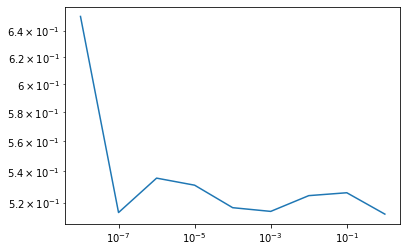

In [ ]:
start_lr = 1e-8
end_lr = 1.0

cur_lr = start_lr
lr_multiplier = 10
losses = []
lrs = []
while cur_lr <= end_lr:
    model = get_model(requires_grad=True)
    parameters = model.fc.parameters()   

    params = model.state_dict()
    params.pop('fc.bias')
    params.pop('fc.weight')

    optimizer = optim.Adam( [
        {'params': params.values(), },
        {'params': model.fc.parameters(), 'lr': 1e-3}],
        lr=cur_lr)

    loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, None, 1)

    losses.append(loss_history[0])
    lrs.append(cur_lr)
    cur_lr = cur_lr*lr_multiplier 

plt.xscale('log')
plt.yscale('log')

plt.plot(lrs,losses)




Average loss: 0.818825, Train accuracy: 0.507000, Val accuracy: 0.508000
Average loss: 0.735096, Train accuracy: 0.523500, Val accuracy: 0.546000
Average loss: 0.758096, Train accuracy: 0.530000, Val accuracy: 0.584000
Average loss: 0.532523, Train accuracy: 0.733500, Val accuracy: 0.882000
Average loss: 0.253592, Train accuracy: 0.891000, Val accuracy: 0.930000
Average loss: 0.303340, Train accuracy: 0.876500, Val accuracy: 0.850000
Average loss: 1.106573, Train accuracy: 0.522000, Val accuracy: 0.510000
Average loss: 2.626234, Train accuracy: 0.513000, Val accuracy: 0.544000
Average loss: 36.490936, Train accuracy: 0.524000, Val accuracy: 0.526000


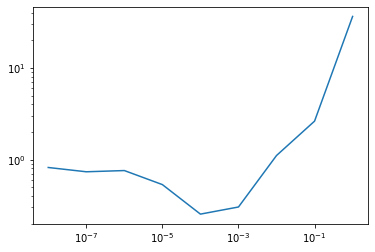

In [ ]:
start_lr = 1e-8
end_lr = 1.0

cur_lr = start_lr
lr_multiplier = 10
losses = []
lrs = []
while cur_lr <= end_lr:
    model = get_model(requires_grad=True)
    parameters = model.fc.parameters()   

    params = model.state_dict()
    params.pop('fc.bias')
    params.pop('fc.weight')

    optimizer = optim.Adam( 
        model.parameters(),
        lr=cur_lr)

    loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, None, 1)

    losses.append(loss_history[0])
    lrs.append(cur_lr)
    cur_lr = cur_lr*lr_multiplier 

plt.xscale('log')
plt.yscale('log')

plt.plot(lrs,losses)




# Обучение на полных данных

Лучший loss=0.25 был получен при использовании Adam с lr=1e-4. Попробуем обучить модель на всех данных

Добавим аугментацию.

In [ ]:
img_transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ColorJitter(),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(degrees=5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
train_dataset = MaleFemaleDataset(train_folder, 
                       transform=img_transform
                      )

In [ ]:
data_size = len(train_dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)


In [ ]:
    model = get_model(requires_grad=True)

    optimizer = optim.Adam( 
        model.parameters(),
        lr=1e-4,
        weight_decay=1e-4,
        )

    loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, None, 12, save=1, save_name='resnet18/model')



Average loss: 0.086684, Train accuracy: 0.967038, Val accuracy: 0.980950
save model to drive/My Drive/Colab Notebooks/models/resnet18/model.0.9809.1600428970.torch
Average loss: 0.055442, Train accuracy: 0.980163, Val accuracy: 0.977600
save model to drive/My Drive/Colab Notebooks/models/resnet18/model.1.9776.1600429355.torch
Average loss: 0.046848, Train accuracy: 0.983813, Val accuracy: 0.977000
save model to drive/My Drive/Colab Notebooks/models/resnet18/model.2.9770.1600429721.torch
Average loss: 0.043122, Train accuracy: 0.984800, Val accuracy: 0.980300
save model to drive/My Drive/Colab Notebooks/models/resnet18/model.3.9803.1600430082.torch
Average loss: 0.037787, Train accuracy: 0.986388, Val accuracy: 0.977950
save model to drive/My Drive/Colab Notebooks/models/resnet18/model.4.9779.1600430439.torch
Average loss: 0.037665, Train accuracy: 0.987325, Val accuracy: 0.982750
save model to drive/My Drive/Colab Notebooks/models/resnet18/model.5.9827.1600430795.torch
Average loss: 0.

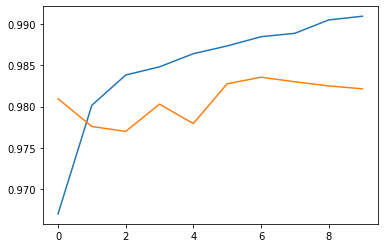

In [ ]:
plt.plot(train_history)
plt.plot(val_history)

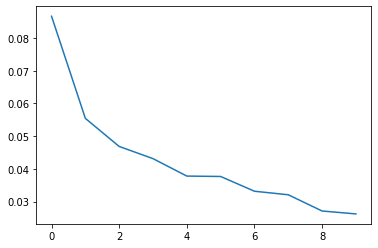

In [ ]:
plt.plot(loss_history)

Видно, что модель переобучается, поскольку accuracy продолжает уверенно расти для обучающей выборки, и почти колеблется на месте для валидационной. Возможно, увеличение количества аугментаций, или смена метода оптимизации помогли бы улучшить ситуацию, но поскольку время ограничено, остановимся пока на этом.  

# Оценка качества модели 

Загрузим лучшую модель и посмотрим, что она предсказывает на валидационной выборке

In [ ]:
path = "drive/My Drive/Colab Notebooks/models/resnet18/model.6.9835.1600431157.torch"
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
model.load_state_dict(torch.load(path, map_location=device))
model=model.eval()


## Визуализируем ошибки модели

Посмотрим, где модель ошибается. Прогоним валидационную выборку через модель, и визуализируем портреты, для которых предсказания отличаются от истинных меток

In [ ]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode

    predictions = np.array([])
    ground_truth = np.array([])
    eval_sampler = SubsetSampler(val_indices)
    eval_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=eval_sampler)

    for i, (x,y,_) in enumerate(eval_loader):    
        image=x.to(device)
        prediction=model(image)
        _, indices = torch.max(prediction, 1)

        ground_truth = np.append(ground_truth, y)
        predictions=np.append(predictions, indices.tolist())

    return predictions, ground_truth



In [ ]:
img_transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
val_dataset = MaleFemaleDataset(train_folder, 
                       transform=img_transform
                      )
predictions, gt = evaluate_model(model, val_dataset, val_indices)


Визуализируем ошибки модели

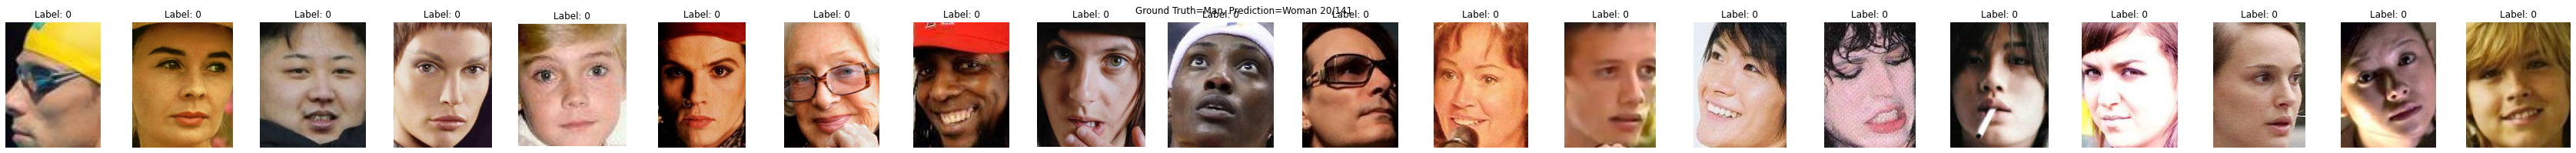

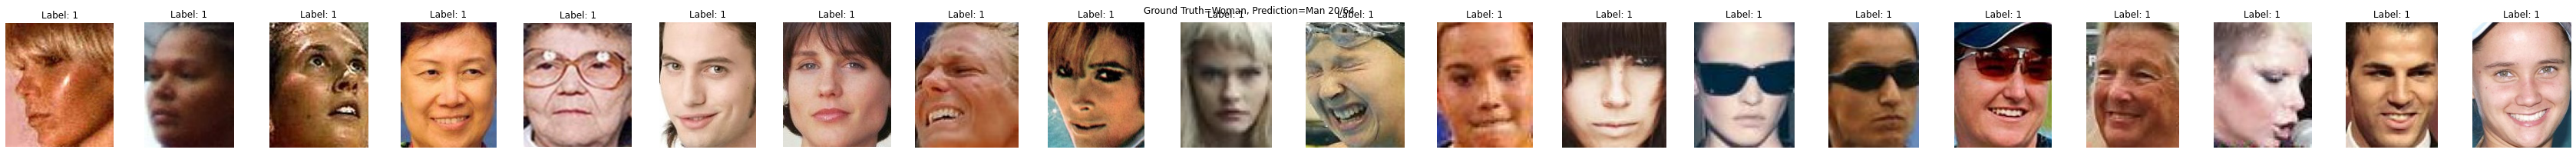

In [29]:
val_indices = np.array(val_indices)

man_woman_indices = val_indices[(predictions==1) & (gt==0)]
woman_man_indices = val_indices[(predictions==0) & (gt==1)]

visualize_samples(orig_dataset, man_woman_indices, "Ground Truth=Man, Prediction=Woman",count=20)
visualize_samples(orig_dataset, woman_man_indices, "Ground Truth=Woman, Prediction=Man",count=20)


Мы видим, что среди  ошибок модели, как для мужчин, так и для женщин есть ошибочно размеченные портреты противоположного пола. Среди мужских портретов также преобладают мужчины с более "женственными" образами - с длинными волосами, макияжем, а также пара портретов, про которые из-за плохого качества нельзя с уверенностью сказать, мужской он или женский. Хотя и явно ошибочные варианты тоже присутствуют 
С женскими портретами дела обстоят похожим образом. Много обшибок разметки, несколько обезличенных портретов неопределенного пола, некоторое количество явных ошибок.
 
Посчитаем accuracy для всей выборки, а так же долю ошибок для каждого класса отдельно и их соотношение. 

In [48]:
accuracy = len(predictions[predictions==gt])/ len(predictions)
print("Accuracy: %f" % accuracy)

Accuracy: 0.989750


In [46]:
man_cnt = len(gt[(gt==0)])
woman_cnt = len(gt[(gt==1)])
false_man_cnt = len(predictions[(predictions==0) & (gt==1)])
true_man_cnt = len(predictions[(predictions==0) & (gt==0)])
false_woman_cnt = len(predictions[(predictions==1) & (gt==0)])
true_woman_cnt = len(predictions[(predictions==1) & (gt==1)])

woman_error_rate = false_man_cnt/ woman_cnt
man_error_rate = false_woman_cnt/ man_cnt

print("Man error rate: %.3f, Woman error rate: %.3f, " % (man_error_rate, woman_error_rate))
print("Man accuracy: %.3f, Woman accuracy: %.3f" % (true_man_cnt/ man_cnt, true_woman_cnt/ woman_cnt))
print("Man Error Rate/ Woman Error Rate: %.3f" % (man_error_rate/ woman_error_rate) )

Man error rate: 0.014, Woman error rate: 0.006, 
Man accuracy: 0.986, Woman accuracy: 0.994
Man Error Rate/ Woman Error Rate: 2.177


Видим, что среди мужских портретов ошибок в 2 раза больше чем среди женских. Посмотрим еще на абсолютные значения ошибок

In [55]:
print("False woman cnt: %d, False man cnt: %d" % (false_woman_cnt, false_man_cnt))

False woman cnt: 141, False man cnt: 64


Абсолютные цифры небольшие, делать выводы об их соотношении смысла нет